In [1]:
!pip install torchdata
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# reproducibility 
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [3]:
torch.__version__

'1.13.1+cu116'

In [4]:
torchtext.__version__

'0.14.1'

In [5]:
torchdata.__version__

'0.5.1'

In [6]:
# torch.cuda.get_device_name(0)

## 1. Loading the Dataset

In [7]:
# for puffer
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import SST2

train = SST2(split='train')
test = SST2(split='dev')

In [8]:
train  # a new object by torchdata.....streaming data (yield ....)

ShardingFilterIterDataPipe

## 2. EDA - Exploratory Data Analysis

In [9]:
next(iter(train))  # generator
# (negative, positive)
#     0,        1

('hide new secretions from the parental units', 0)

In [10]:
list(iter(train))[100]  # generator
# (negative, positive)
#     0,        1

/usr/local/lib/python3.8/dist-packages/torch/utils/data/datapipes/iter/combining.py:262: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


('in memory', 1)

In [11]:
set([y for x, y in list(iter(train))])

{0, 1}

In [12]:
train_size = len(list(iter(train)))
train_size

67349

In [13]:
train

ShardingFilterIterDataPipe

In [14]:
# splitting data
train, valid = train.random_split(total_length=train_size, 
                                  weights = {"train": 0.8,
                                             "valid": 0.2},
                                  seed = SEED)

In [15]:
train_size = len(list(iter(train)))
val_size   = len(list(iter(valid)))
test_size  = len(list(iter(test)))

In [16]:
train_size, val_size, test_size

(53879, 13470, 872)

## 3. Preprocessing

In [17]:
## 3.1 Tokenizing

from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# checking whether the tokenizer works.....
tokens    = tokenizer("Chaky likes deep learning very much and wants his student to be number 1 in Asia....")
tokens

['Chaky',
 'likes',
 'deep',
 'learning',
 'very',
 'much',
 'and',
 'wants',
 'his',
 'student',
 'to',
 'be',
 'number',
 '1',
 'in',
 'Asia',
 '....']

In [18]:
next(iter(train))

('contains no wit , only labored gags', 0)

In [19]:
## 3.2 Numericalization

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  # data_iter, e.g., train
    for text, _ in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [20]:
vocab.set_default_index(vocab["<unk>"]) # if we don't the id of this word, we can set it unk

In [21]:
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.'])

[0, 979, 42, 3751, 10, 26, 975, 2792, 9]

In [22]:
id2word = vocab.get_itos()

In [23]:
id2word[0]

'<unk>'

In [24]:
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [25]:
len(vocab)  # 13k unique words.....

13767

## 4. FastText Embedding

In [26]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

.vector_cache/wiki.simple.vec: 293MB [00:18, 16.0MB/s]                           
100%|██████████| 111051/111051 [00:11<00:00, 9262.98it/s] 


In [27]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [28]:
fast_embedding.shape # (vocab size, 300) == (13k, 300)

torch.Size([13767, 300])

In [29]:
# looking up the fasttext embedding of id 100
fast_embedding[100][:10] #size of 300 dim of this word id 100

tensor([-0.3211, -0.1398, -0.0777, -0.1825, -0.2469,  0.1847, -0.3431,  0.0689,
         0.1011, -0.0628], device='cuda:0')

## 5. Preparing Dataloader

In [30]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)   # 0, 1

In [31]:
'''
why padding????

in the same batch, e.g., batch size = 2

"chaky eat sushi", ==> "chaky", "eat", "sushi" ==> 0, 22, 11, 1, 1
"chaky sleep" ==> "chaky", "sleep" ==> 0, 99, 1, 1, 1

'''

'\nwhy padding????\n\nin the same batch, e.g., batch size = 2\n\n"chaky eat sushi", ==> "chaky", "eat", "sushi" ==> 0, 22, 11, 1, 1\n"chaky sleep" ==> "chaky", "sleep" ==> 0, 99, 1, 1, 1\n\n'

In [32]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence # making each batch same length

pad_ix = vocab['<pad>']

# this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))  
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) 
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) # for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [33]:
batch_size = 64

train_loader = DataLoader(train, batch_size = batch_size, 
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(valid, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [34]:
# for label, text, length in train_loader:
#     break

# label: [batch size, ]
# text : [batch size, longest length of this batch] ==> [batch size, seq len] ==> [b, l]
# length:[batch size, ]

# label, text, length  # why we need length --> we can later ignore padding....

## 6. Designing the Model

In [35]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        # putting padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        # text = [batch size, seq len]
        embedded = self.embedding(text)
        
        # ++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        # embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        # ++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # output = [batch size, seq len, hidden dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        # hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

# 7. Training

In [36]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [37]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300 # FastText embedding
output_dim = 2 # two classes

# for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [38]:
# printing the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4130100
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  1024
     2
______
6850870


In [39]:
import torch.optim as optim

lr=1e-3

# training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # combining softmax with cross entropy

In [40]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [41]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() # useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) # (batch_size, )
        text = text.to(device) # (batch_size, seq len)
                
        # prediction
        predictions = model(text, text_length).squeeze(1) # output by the fc is (batch_size, 1), thus need to remove this 1
        
        # calculating loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [42]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) # (batch_size, )
            text  = text.to(device)  # (seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

# 8. Putting everuthing together

In [43]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    # for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 18s
	Train Loss: 0.120 | Train Acc: 95.68%
	 Val. Loss: 0.073 |  Val. Acc: 97.35%
Epoch: 02 | Time: 0m 17s
	Train Loss: 0.090 | Train Acc: 96.65%
	 Val. Loss: 0.062 |  Val. Acc: 97.80%
Epoch: 03 | Time: 0m 17s
	Train Loss: 0.070 | Train Acc: 97.40%
	 Val. Loss: 0.048 |  Val. Acc: 98.13%
Epoch: 04 | Time: 0m 18s
	Train Loss: 0.058 | Train Acc: 97.82%
	 Val. Loss: 0.036 |  Val. Acc: 98.70%
Epoch: 05 | Time: 0m 18s
	Train Loss: 0.047 | Train Acc: 98.14%
	 Val. Loss: 0.032 |  Val. Acc: 98.76%


# 9. Plotting Loss and Accuracy

Text(0, 0.5, 'loss')

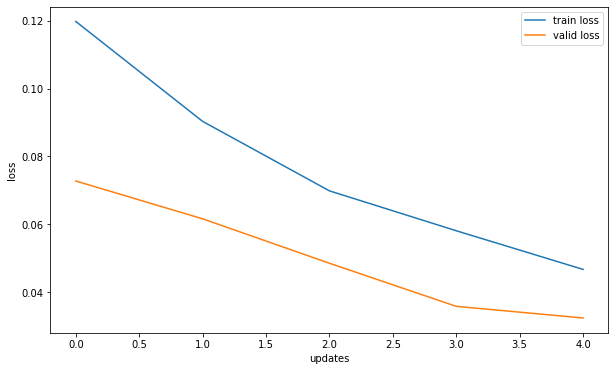

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

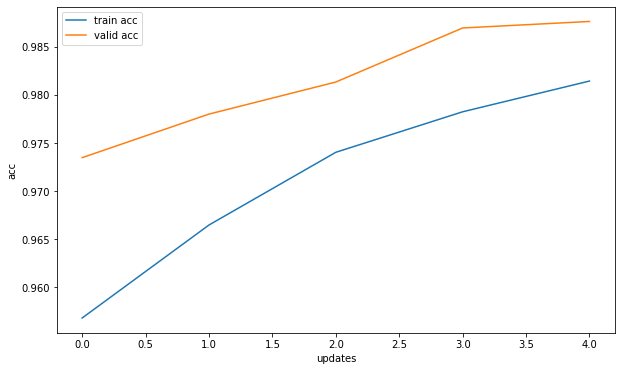

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [51]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.746 | Test Acc: 81.76%


# 10. Testing on Random Data

In [52]:
test_str = "This movie illustrates gender roles during the nineteenth century by focusing on the life experiences of four sisters from childhood to adulthood."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([   0,   23, 4175, 2716, 1976,  770,    4,    0, 1543,   31, 9877,   29,
           4,   82, 2327,    8,  588, 3033,   43, 2225,   10,    0,    9],
       device='cuda:0')

In [53]:
text_list = [x.item() for x in text]
text_list

[0,
 23,
 4175,
 2716,
 1976,
 770,
 4,
 0,
 1543,
 31,
 9877,
 29,
 4,
 82,
 2327,
 8,
 588,
 3033,
 43,
 2225,
 10,
 0,
 9]

In [54]:
# we can reverse it....
mapping = vocab.get_itos()

# printing 159, for example
mapping[159]

'hard'

In [55]:
[mapping[num] for num in text_list]

['<unk>',
 'movie',
 'illustrates',
 'gender',
 'roles',
 'during',
 'the',
 '<unk>',
 'century',
 'by',
 'focusing',
 'on',
 'the',
 'life',
 'experiences',
 'of',
 'four',
 'sisters',
 'from',
 'childhood',
 'to',
 '<unk>',
 '.']

In [56]:
text = text.reshape(1, -1)  #because batch_size is 1

In [57]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [58]:
text.shape

torch.Size([1, 23])

In [59]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [60]:
predict(text, text_length)

tensor([1], device='cuda:0')

## 10.1 Testing on Negative-Negative Sentence

In [61]:
# 1st sentence
negneg_test = "The movie was not unpleasant and also it did not earn less popularity."
text = torch.tensor(text_pipeline(negneg_test)).to(device)
text

tensor([   0,   23,  105,   37, 1309,    7,  169,   16,  297,   37, 3846,  185,
        6427,    9], device='cuda:0')

In [62]:
text_list = [x.item() for x in text]
text_list

[0, 23, 105, 37, 1309, 7, 169, 16, 297, 37, 3846, 185, 6427, 9]

In [63]:
text = text.reshape(1, -1)  

In [64]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [65]:
text.shape

torch.Size([1, 14])

In [66]:
predict(text, text_length)

tensor([0], device='cuda:0')

In [85]:
# 2nd sentence
negneg_test = "The show was not that bad."
text = torch.tensor(text_pipeline(negneg_test)).to(device)
text

tensor([  0, 327, 105,  37,  76,   9], device='cuda:0')

In [86]:
text_list = [x.item() for x in text]
text_list

[0, 327, 105, 37, 76, 9]

In [87]:
text = text.reshape(1, -1)

In [88]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [89]:
text.shape

torch.Size([1, 6])

In [90]:
predict(text, text_length)

tensor([1], device='cuda:0')

## 10.2 Testing on Negative-Positive Sentence

In [91]:
# 1st sentence
negpos_test = "The audience did not enjoy the flim that released last week."
text = torch.tensor(text_pipeline(negpos_test)).to(device)
text

tensor([    0,   136,   297,    37,   344,     4, 13302,    14,  2356,   332,
         1221,     9], device='cuda:0')

In [92]:
text_list = [x.item() for x in text]
text_list

[0, 136, 297, 37, 344, 4, 13302, 14, 2356, 332, 1221, 9]

In [93]:
text = text.reshape(1, -1)

In [94]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [95]:
text.shape

torch.Size([1, 12])

In [96]:
predict(text, text_length)

tensor([0], device='cuda:0')

In [97]:
# 2nd sentence
negpos_test = "The movie was not worth of the ticket price."
text = torch.tensor(text_pipeline(negpos_test)).to(device)
text

tensor([   0,   23,  105,   37,  204,    8,    4, 1773, 1438,    9],
       device='cuda:0')

In [98]:
text_list = [x.item() for x in text]
text_list

[0, 23, 105, 37, 204, 8, 4, 1773, 1438, 9]

In [99]:
text = text.reshape(1, -1)

In [100]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [101]:
text.shape

torch.Size([1, 10])

In [102]:
predict(text, text_length)

tensor([0], device='cuda:0')